# Решение задачи:

Так как в данном коде используется **TPU v2-8**, то стоит отдельно произвести установку **tensorflow**:

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.6 MB/s eta 0:00:00


Импортируем нужные нам библиотеки:

In [ ]:
import numpy as np
from random import randint
import unicodedata
import re
import os
import time
import pandas as pd
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, GRU, Input, Dense, Embedding, Bidirectional, Concatenate, Dropout, Dot
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Добавим **mixed precision training** для ускорения работы кода:

In [ ]:
from tensorflow.keras.mixed_precision import Policy, set_global_policy

try:
    set_global_policy(Policy("mixed_bfloat16")) # Для TPU используем bfloat16
    print("✅ Включена mixed precision (bfloat16) для TPU")
except:
    print("⚠️ Mixed precision недоступна. Продолжаем в float32 режиме")

✅ Включена mixed precision (bfloat16) для TPU


Скачаем текстовый документ с диалогами:

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt

--2025-09-03 17:04:04--  https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243904 (238K) [text/plain]
Saving to: ‘dialogs.txt’

dialogs.txt         100%[===================>] 238.19K   477KB/s    in 0.5s    

2025-09-03 17:04:05 (477 KB/s) - ‘dialogs.txt’ saved [243904/243904]



Определение констант:

In [ ]:
BATCH_SIZE     = 128           # размер обучающего пакета.
EPOCHS         = 30            # число эпох обучения.
UNITS          = 512           # число нейронов в рекуррентных с слоях.
EMBED_DIM      = 128           # размерность эмбеддинга.
NUM_SAMPLES    = 50000         # число примеров для обучения.
FILE_NAME      = "dialogs.txt" # имя файла со словарем в архиве
SOS            = '<start>'     # токен начала последовательсти
EOS            = '<end>'       # токен окончания последовательсти

Фразы необходимо подготовить: добавить пробелы между словами и знаками препинания, спец. символы необходимо заменить на пробелы, убрать пробелы в начале и конце фразы. Также необходимо добавить токены начала последовательности `SOS` и ее окончания `EOS`:

In [ ]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,;:¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?'`.!,;:¿]+", " ", w)
    w = w.rstrip().strip()

    # Добавляем в фразу токены SOS и EOS
    w = SOS + ' ' + w + ' ' + EOS
    return w

Далее сформируем  выборку из `NUM_SAMPLES` примеров. По аналогии с чат-ботами мы сформируем массивы из входных фраз `questions` (вопросов) и выходных `answers` (ответов), а также определим токены начала последовательности `SOS` и токены окончания последовательности `EOS`:

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # список входных фраз
answers = []   # список ответных фраз

with open(FILE_NAME, "r", encoding="utf-8") as f: # открываем файл в режиме чтения
    lines = f.read().split("\n")                  # считываем весь файл, разделяя на строки

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    # Разделяем строку по табам (входные данные, выходные и ненужный столбец)
    input_text, target_text = line.split("\t")

    # Подготовка данных
    questions.append(preprocess_sentence(input_text))
    answers.append(preprocess_sentence(target_text))

print("Число примеров:", len(answers))

#  Получим случайный вопрос и ответ
random_index = randint(0, len(questions)-1)
print(f'Вопрос : {questions[random_index]}') # Пример входной фразы
print(f'Ответ : {answers[random_index]}')    # Пример ответной фразы

Число примеров: 3724
Вопрос : <start> where do you want to go ? <end>
Ответ : <start> we can go to the river . <end>


Создадим для каждого языка свой персональный токенизатор с помощью функции:

In [ ]:
def tokenize(text): # функция принимает текст на заданном языке
    # Создадим токенайзер
    tokenizer = Tokenizer(filters='')

    # Загружаем в токенизатор тексты для обработки и сборки словаря частотности
    tokenizer.fit_on_texts(text)

    # Векторизируем фразы
    seq = tokenizer.texts_to_sequences(text)

    # Делаем последовательности одной длины, заполняя нулями короткие фразы
    pseq = pad_sequences(seq, padding='post')

    # Возвращаем последовательность индексов и токенизатор
    return pseq, tokenizer

Функция вернет нам последовательность индексов и токенизатор на заданном языке:

In [ ]:
paddedQuestions, tokenizer_input = tokenize(questions)    # формируем вектор фикс длины для вопросов
paddedAnswers, tokenizer_output = tokenize(answers)      # формируем вектор фикс длины для ответов

Определим максимальную длину русских и английских фраз:

In [ ]:
max_length_output = paddedAnswers.shape[1]
max_length_input = paddedQuestions.shape[1]

Создадим обучающую и проверочную выборки в соотношении **80/20**:

In [ ]:
questions_train, questions_val, answers_train, answers_val = train_test_split(paddedQuestions, paddedAnswers, test_size=0.2)

Этот код определяет ключевые параметры для обучения: `BUFFER_SIZE` задает объем данных для перемешивания при создании датасета, `STEPS_PER_EPOCH` вычисляет количество итераций на одну эпоху в зависимости от размера батча, а `VOCAB_INPUT_SIZE` и `VOCAB_OUTPUT_SIZE` определяют размеры словарей для входных и выходных последовательностей, добавляя 1 для учета специального токена неизвестных слов:

In [ ]:
# Определим параметры
BUFFER_SIZE = len(questions_train)                     # случайно сэмплировать будем по всей длине обучающейся выборки
STEPS_PER_EPOCH = len(questions_train)//BATCH_SIZE     # количество шагов в одной эпохе

VOCAB_INPUT_SIZE = len(tokenizer_input.word_index) + 1
VOCAB_OUTPUT_SIZE = len(tokenizer_output.word_index) + 1

Преобразуем закодированные последовательности обратно в читаемый текст, отображая соответствие между числовыми индексами и словами из словаря:

In [ ]:
# Маппинг данных из индексов в слова
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Вопрос:")
convert(tokenizer_input, questions_train[0])
print ()
print ("Ответ:")
convert(tokenizer_output, answers_train[0])

Вопрос:
1 ----> <start>
5 ----> i
46 ----> think
11 ----> it
2034 ----> depends
36 ----> on
8 ----> the
1332 ----> season
17 ----> and
36 ----> on
43 ----> your
1333 ----> cabin
3 ----> .
2 ----> <end>

Ответ:
1 ----> <start>
56 ----> well
6 ----> ,
15 ----> of
85 ----> course
4 ----> i
58 ----> want
9 ----> to
44 ----> go
89 ----> when
8 ----> the
159 ----> weather
17 ----> is
82 ----> nice
3 ----> .
2 ----> <end>


Создадим датасет `tf.data.Dataset` из массивов **Numpy** со случайной подачей тренировочных сэмплов в процессе обучения:

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((questions_train, answers_train))  # Создаем датасет из пар (вопросы, ответы), разделяя по первой оси
dataset = dataset.shuffle(BUFFER_SIZE)  # Перемешиваем данные с использованием буфера размером BUFFER_SIZE для лучшей рандомизации
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # Группируем данные в батчи фиксированного размера, отбрасывая неполный последний батч
dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Настраиваем предзагрузку следующего батча параллельно с обработкой текущего для ускорения обучения
dataset = dataset.cache()  # Кэшируем весь датасет в памяти после первой эпохи, ускоряя последующие проходы по данным

Посмотрим на форму примеров полученных батчей:

In [ ]:
example_questions_batch, example_answers_batch = next(iter(dataset))
print('Форма батчей вопросов и ответов: ', example_questions_batch.shape, example_answers_batch.shape)

Форма батчей вопросов и ответов:  (128, 24) (128, 24)


Первым шагом в создании модели `seq2seq` с механизмом внимания является создание кодировщика. Мы создадим кодировщик со слоем `Embedding`, за которым следует слой **GRU** (**Gated Recurrent Unit**). Вводимая последовательность, сначала проходит через слой `Embedding`, а затем в слой `GRU`. На выходе `GRU` получаем выходные данные блока кодировщика и скрытое состояние.     
В качестве рекуррентного слоя мы выбрали `GRU` и инициализацируем его веса с помощью **метода Ксавьера** `lorot_uniform` для упрощения прохождения сигнала при распространении ошибки. Что значительно экономит ресурсы.

Рассмотрим архитектуру класса кодировщика  `Encoder`. Мы наследуем класс от базового класа `Model` в **Keras**, и сможем его использовать аналогично слою. На самом деле мы могли бы наследовать класс и от другого базового класса **Keras** - `Layer`. Для нашей задачи оба варианта идентичны! В литературе и в примерах на **GitHub**, **Хабре** и т. д. вы можете встретить оба подхода.

Класс должен включать два метода `__init__()` и `call()`:

В метод `__init__()` при инициализации класса передаем параметры: размер словаря `vocab_size`, размер пространства эмбеддинга `embedding_dim`, число нейронов в **GRU** `enc_units`, размер пакета `batch_sz`.

В методе `call()` определяем структуру (или "прямое распространение в сети кодировщика", если говорить более научным языком.

Кроме того, мы определим метод `initialize_hidden_state()` для инициализации скрытого состояния с размерами `batch_size` и `enc_units`:

In [ ]:
class Encoder(tf.keras.Model):
  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размер пространства эмбеддинга
               enc_units,     # число нейронов в GRU
               batch_sz):     # размер батча

    super(Encoder, self).__init__()                                   # вызываем инициализацию родительского класса
    self.batch_sz = batch_sz                                          # инициализируем переменную размера батча внутри класса
    self.enc_units = enc_units                                        # инициализируем переменную размера слоя в кодировщике
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)             # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

  # Метод принимает входную фразу и начальное состояние
  def call(self,
           x,         # входная фраза
           hidden):   # начальное состояние

    x = self.embedding(x)   # входящие тензоры преобразовываются эмбеддингом
    output, state = self.gru(x, initial_state = hidden) # далее пропускаем через слой GRU и получаем выходные данные и новое состояние

    # Получаем форму output: (batch size, max_length, hidden_size)
    # Получаем форму state: (batch size, hidden_size)
    # sequence length == max_length
    # units == hidden_size
    return output, state # выход сети и состояние на выходе

  # Создаем метод инициализации состояний на скрытых слоях
  # Вернем тензор из нулей размер батча на размер слоя, его будем использовать как начальное состояние энкодера
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(VOCAB_INPUT_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

Данный класс определяет универсальный класс механизма внимания, который поддерживает четыре типа внимания: **Bahdanau (Additive), Luong Dot, Luong General и Luong Concat.** В конструкторе инициализируются необходимые слои в зависимости от выбранного режима, а в методе `call` реализованы разные формулы вычисления весов внимания для каждого типа. Для **Bahdanau** используется аддитивная модель с **tanh-активацией**, для **Luong Dot** — простое скалярное произведение, для **Luong General** — преобразование скрытого состояния перед умножением, а для **Luong Concat** — конкатенация состояний с последующим преобразованием. После вычисления оценки важности применяется **softmax** для получения нормализованных весов внимания, на основе которых формируется итоговый вектор контекста как взвешенная сумма всех состояний энкодера.

In [ ]:
class AttentionMechanism(Model):
    def __init__(self,
                 units,
                 mode='bahdanau'):  # Для выбора типа внимания
        super(AttentionMechanism, self).__init__()
        self.mode = mode
        self.units = units

        # Инициализация слоев в зависимости от выбранного режима
        if mode == 'bahdanau':
            # Оригинальный механизм Богданова (Additive attention)
            self.W1 = Dense(units)
            self.W2 = Dense(units)
            self.V = Dense(1)
        elif mode == 'luong_general':
            # Luong General attention: добавляет преобразование скрытого состояния
            self.W = Dense(units)
        elif mode == 'luong_concat':
            # Luong Concat attention: конкатенация состояний перед применением функции
            self.W = Dense(units)
            self.v = Dense(1)
        # Для luong_dot не требуется дополнительных слоев

    def call(self, hidden_state, values):
        # Расширяем размерность hidden_state для совместимости с values
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

        if self.mode == 'bahdanau':
            # Bahdanau (Additive) attention
            score = self.V(tf.nn.tanh(
                self.W1(values) + self.W2(hidden_with_time_axis)))

        elif self.mode == 'luong_dot':
            # Luong Dot Product attention
            # Транспонируем values для матричного умножения: (batch_size, hidden_size, max_length)
            values_transposed = tf.transpose(values, perm=[0, 2, 1])
            # Вычисляем скалярное произведение
            score = tf.matmul(hidden_with_time_axis, values_transposed)
            # Возвращаем форму score к (batch_size, max_length, 1)
            score = tf.transpose(score, perm=[0, 2, 1])

        elif self.mode == 'luong_general':
            # Luong General attention
            # Преобразуем hidden_state перед скалярным произведением
            transformed_hidden = self.W(hidden_state)
            transformed_hidden = tf.expand_dims(transformed_hidden, 1)
            # Транспонируем values для матричного умножения
            values_transposed = tf.transpose(values, perm=[0, 2, 1])
            # Вычисляем скалярное произведение с преобразованным hidden_state
            score = tf.matmul(transformed_hidden, values_transposed)
            # Возвращаем форму score к (batch_size, max_length, 1)
            score = tf.transpose(score, perm=[0, 2, 1])

        elif self.mode == 'luong_concat':
            # Luong Concat attention
            # Повторяем hidden_state для каждого временного шага
            hidden_repeated = tf.repeat(hidden_with_time_axis,
                                       repeats=tf.shape(values)[1],
                                       axis=1)
            # Конкатенируем состояния
            concat = tf.concat([hidden_repeated, values], axis=-1)
            # Применяем преобразование
            score = self.v(tf.nn.tanh(self.W(concat)))

        else:
            raise ValueError(f"Неизвестный режим внимания: {self.mode}")

        # Применяем softmax для получения весов внимания
        attention_weights = tf.nn.softmax(score, axis=1)

        # Вычисляем вектор контекста как взвешенную сумму значений
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

attention_layer = AttentionMechanism(10, mode='bahdanau')

Рассмотрим класс декодировщика. Он также имеет два метода: `__init__()` и `call()`.

В метод `__init__()` передаем параметры: размер словаря `vocab_size`, размерность пространства эмбеддинга `embedding_dim`, число нейронов в GRU `dec_units`, размер батча `batch_sz`. При создании экземпляра класса в методе `__init__()` инициализируем размер пакета, число нейронов в слоях декодирования, определяем слои эмбэддинга, GRU и Dense слой. Кроме того, создается экземпляр класса `AttentionMechanism`. Аналогично кодировщику, в качестве рекуррентного слоя мы берем GRU и инициализацируем его веса с помощью метода Ксавьера `lorot_uniform` для упрощения прохождения сигнала при распространении ошибки.

В методе `call()`:

* Вызываем прямое распространение через механизм внимания и вычисляем вектор контекста и коэффициенты внимания.
* Пропускаем целевую последовательность через слой эмбеддинга.
* Объединяем выходной сигнал из эмбеддинга и вектор контекста.
* Подключаем выходной сигнал к слою GRU, а затем к полносвязному слою.

In [ ]:
class Decoder(Model):
    # Конструктор класса
    def __init__(self,
                 vocab_size,    # размер словаря
                 embedding_dim, # размерность пространства эмбеддинга
                 dec_units,     # число нейронов в GRU
                 batch_sz):     # размер батча
        super(Decoder, self).__init__()                       # вызываем инициализацию родительского класса
        self.batch_sz = batch_sz                              # инициализируем переменную размера батча внутри класса
        self.dec_units = dec_units                            # инициализируем переменную размера слоя в декодировщике
        self.embedding = Embedding(vocab_size, embedding_dim) # инициализируем слой эмбеддинга с заданными параметрами

        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

        self.fc = Dense(vocab_size) # полносвязный слой с размером словаря

        self.attention = AttentionMechanism(self.dec_units, mode='bahdanau')  # по умолчанию Bahdanau

    def call(self,
             x,           # начальный токен входной последовательности
             hidden,      # состояние кодировщика
             enc_output   # выход кодировщика
            ):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Форма x после прохождения через  embedding: (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # Дальше конкатенируем с вектором контекста и получаем (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
        output, state = self.gru(x, initial_state = hidden)

        # Форма output: (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # Пропускаем через полносвязный слой
        x = self.fc(output)

        # Форма выходной фразы: (batch_size, vocab)
        # Вернем выходную фразу, вектор состояния, веса внимания
        return x, state, attention_weights

# Создали декодировщик с параметрами
decoder = Decoder(VOCAB_OUTPUT_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

Оптимизатор будем использовать `Adam`. Функция потерь `loss_function` принимает на вход истинную и предсказанные выборки. Далее мы применяем маску, которая уберет нулевые индексы в конце фразы. Это те самые нули, которые мы добавляли для выравнивания фраз.  Далее фактические и предсказанные результаты передаем в `SparseCategoricalCrossentropy` и получаем ошибку. К ошибке необходимо применить маску ранее созданную, которая позволит избавиться от нулевых элементов:

In [ ]:
# Оптимизатор Adam
optimizer = tf.keras.optimizers.Adam()

# Функция потерь
def loss_function(real, pred):
  # Не все последовательности имеют одинаковую длину.
  # Если в последовательности есть "0", то соответствующую ей потерю будем обнулять
  # Для этого создадим маску
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # Создаем экземпляр класса SparseCategoricalCrossentropy
  # И сразу вызываем его метод call() с параметрами: истинная и предсказанная фраза
  # Получаем тензор ошибки
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype) # приводим тип маски к типу потерь
  loss *= mask                           # маскируем потери, избавляемся от заполняющих нулей

  return tf.reduce_mean(loss) # вернем среднее значение тензора

В процессе обучения мы будем сохранять веса моделей:

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Этот код определяет оптимизированную функцию обучения для **TPU**, которая вычисляет потери и обновляет веса модели с использованием механизма **teacher forcing technique**, включая защиту от пустых последовательностей, фильтрацию некорректных градиентов и явное указание типов данных для максимальной производительности на **TPU**, при этом сохраняя основную структуру процесса обучения **seq2seq** модели с механизмом внимания. Декоратор `@tf.function(jit_compile=True)` компилирует функцию непосредственно для **TPU**, а использование `tf.shape` вместо Python-операций сохраняет выполнение в графовом режиме для ускорения вычислений:

In [ ]:
@tf.function(jit_compile=True)  # Ключевое изменение для TPU
def train_step(inp, targ, enc_hidden):
  loss = 0.0  # Явно указываем float

  # Проверка на пустые последовательности
  if tf.shape(targ)[1] <= 1:
      return tf.constant(0.0, dtype=tf.float32)

  with tf.GradientTape() as tape:
    # Передаем входную последовательность и начальное состояние кодировщика
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden используется вниманием
    dec_hidden = enc_hidden

    # SOS <start> токен инициализирует вход декодировщика
    dec_input = tf.expand_dims([tokenizer_output.word_index[SOS]] * BATCH_SIZE, 1)

    # teacher forcing technique
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Вычисляем среднюю потерю (используем tf.shape вместо Python int)
  seq_length = tf.shape(targ)[1]
  batch_loss = loss / tf.cast(seq_length - 1, tf.float32)  # -1 потому что начинаем с 1

  # Получаем переменные модели
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Вычисляем градиенты
  gradients = tape.gradient(loss, variables)

  # Фильтруем None градиенты (критически важно для TPU)
  filtered_gradients = [(g, v) for g, v in zip(gradients, variables) if g is not None]
  if filtered_gradients:
      grads, vars = zip(*filtered_gradients)
      optimizer.apply_gradients(zip(grads, vars))

  # Явно возвращаем float32
  return tf.cast(batch_loss, tf.float32)

Теперь инициализируем сам цикл обучения. Запускаем цикл в течение заданного количества периодов. Сначала инициализируем скрытое состояние кодировщика, используя метод `initialize_hidden_state()`. Перебираем набор данных по одному пакету за раз (за каждую эпоху). Для каждого пакета необходимо вызвать метод `train_step()` и вычислить потери. Процедуру повторяем для всех эпох:

In [ ]:
# Цикл обучения
for epoch in range(EPOCHS):
  start = time.time()

  # Инициализация скрытого состояния
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Цикл по всему датасету
  for (batch, (inp, targ)) in enumerate(dataset.take(STEPS_PER_EPOCH)):

    # Вызываем метод обучения
    batch_loss = train_step(inp, targ, enc_hidden)

    # Вычисляем потери по пакетам
    total_loss += batch_loss

  # Сохраняем чекпоинты каждые 5 эпох
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # статистика по каждой эпохе
  print(f'Эпоха: {epoch + 1}  |  Потеря:  {(total_loss / STEPS_PER_EPOCH):.4f}  |  Время на эпоху: {time.time() - start} сек \n' )

Эпоха: 1  |  Потеря:  2.2841  |  Время на эпоху: 220.64851713180542 сек 

Эпоха: 2  |  Потеря:  1.9658  |  Время на эпоху: 178.52507328987122 сек 

Эпоха: 3  |  Потеря:  1.8908  |  Время на эпоху: 178.6964406967163 сек 

Эпоха: 4  |  Потеря:  1.8506  |  Время на эпоху: 180.90854597091675 сек 

Эпоха: 5  |  Потеря:  1.7951  |  Время на эпоху: 179.50384998321533 сек 

Эпоха: 6  |  Потеря:  1.7264  |  Время на эпоху: 178.5981183052063 сек 

Эпоха: 7  |  Потеря:  1.6560  |  Время на эпоху: 178.9877414703369 сек 

Эпоха: 8  |  Потеря:  1.5902  |  Время на эпоху: 178.69879579544067 сек 

Эпоха: 9  |  Потеря:  1.5295  |  Время на эпоху: 178.89617538452148 сек 

Эпоха: 10  |  Потеря:  1.4759  |  Время на эпоху: 179.1317915916443 сек 

Эпоха: 11  |  Потеря:  1.4301  |  Время на эпоху: 178.67888045310974 сек 

Эпоха: 12  |  Потеря:  1.3842  |  Время на эпоху: 178.9056522846222 сек 

Эпоха: 13  |  Потеря:  1.3386  |  Время на эпоху: 179.39783310890198 сек 

Эпоха: 14  |  Потеря:  1.3010  |  Время

Алгоритм следующей функции:

1. Начнем с инициализации пустой диаграммы внимания, которая будет построена позже, с помощью `max_length_output` по оси `Y` и `max_length_input` по оси `X`;

2. Предварительно необходимо выполнить предобработку фразы и преобразовать ее в тензор;

3. Инициализируем пустое скрытое состояние, которое будет использоваться при инициализации кодировщика. Инициализацию произведем с помощью метода `initialize_hidden_state()` в классе `encoder`, в результате чего получим выходное скрытое состояние, имеющее размеры `batch_size * hidden_units`;

4. Вызываем класс `encoder` и получаем выходные данные кодировщика и конечное скрытое состояние;

5. Используя цикл `max_length_output`, вызываем класс `decoder`, в котором `dec_input` - это токен `<start>`, `dec_hidden state` - это скрытое состояние кодировщика, а `enc_out` - это выходные данные кодировщика. Получаем выходные данные декодировщика, скрытое состояние и коэфиициенты внимания (еще их называют веса внимания, но мы используем термин коэффициенты, чтобы не путаться с весами модели);

6. Создадим график, используя значения коэффициентов внимания. Извлечем предсказанный токен с максимальным вниманием. Добавим токен к результату и перейдем к следующей итерации, повторяем пока не будет достигнут токен `<end>`;

7. Следующим вводом декодера будет ранее предсказанный индекс (относящийся к токену).

Напишем теперь функцию `evaluate()`:

In [ ]:
def evaluate(sentence):
  # График внимания (будет построен позже)
  attention_plot = np.zeros((max_length_output, max_length_input))

  sentence = preprocess_sentence(sentence)

  # Приведем предложение к нижнему регистру и разобьем на слова
  words = sentence.split(' ')
  inputs = list() # список для сбора токенов

  # Для каждого слова в предложении найдем токен в словаре, если не найдем, то пропустим
  for word in words:
      try:
          inputs.append(tokenizer_input.word_index[word])
      except:
          pass # игнорируем слово, которое не знаем

  # Зафиксируем длину последовательности, дополнив нулями
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_input,
                                                         padding='post')
  # Конвертируем вход в тензор
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([tokenizer_output.word_index[SOS]], 0)

  # Повторяйте цикл до тех пор, пока не будет достигнута максимальная длина для целевого языка
  for t in range(max_length_output):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Сохраняем значения коэффициентов внимания
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Получаем предсказание с максимальным вниманием
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Добавляем токены к результату
    result += tokenizer_output.index_word[predicted_id] + ' '

    # Если токен <end> достигнут, возвращаем результат, входные данные и график внимания
    if tokenizer_output.index_word[predicted_id] == EOS:
      return result, sentence, attention_plot

    # Предсказанное значение подается обратно в модель
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

Определим функцию `plot_attention()` для вывода статистики механизма внимания:

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis') # рисуем 2d матрицу
  fontdict = {'fontsize': 14}           # размер текста

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # вопросы по горизонтали
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # ответы по вертикали

  # Задаем форматирование делений (тикеров) по осям
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.title("Механизм внимания чат-бота")
  plt.xlabel("Вопрос")
  plt.ylabel("Сгенерированный ответ")

  plt.show()

Определим функцию перевода `translate()`, которая внутри будет вызывать функцию `evaluate()`:

In [ ]:
# Функция перевода
def translate(sentence):
  # Вызов функции evaluate()
  result, sentence, attention_plot = evaluate(sentence)

  print('Ввод: %s' % (sentence))
  print(f'Перевод: {result}')

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Восстановим сохраненные чекпоинты модели:

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Напишем 3 примера:

Ввод: <start> how are you ? <end>
Перевод: i think i had a ticket . <end> 


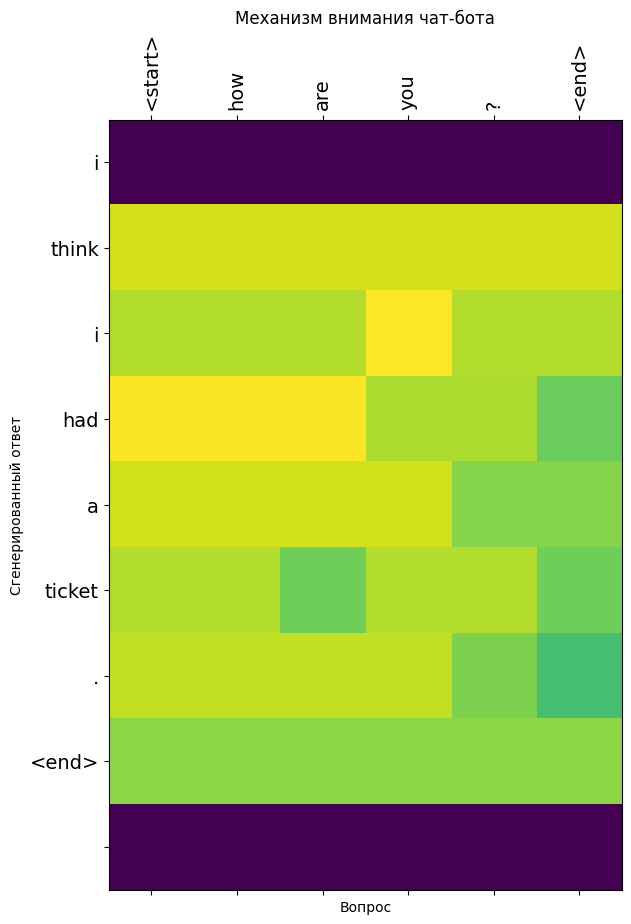

In [ ]:
translate('how are you?')

Ввод: <start> what is your name ? <end>
Перевод: i got laid off because <end> 


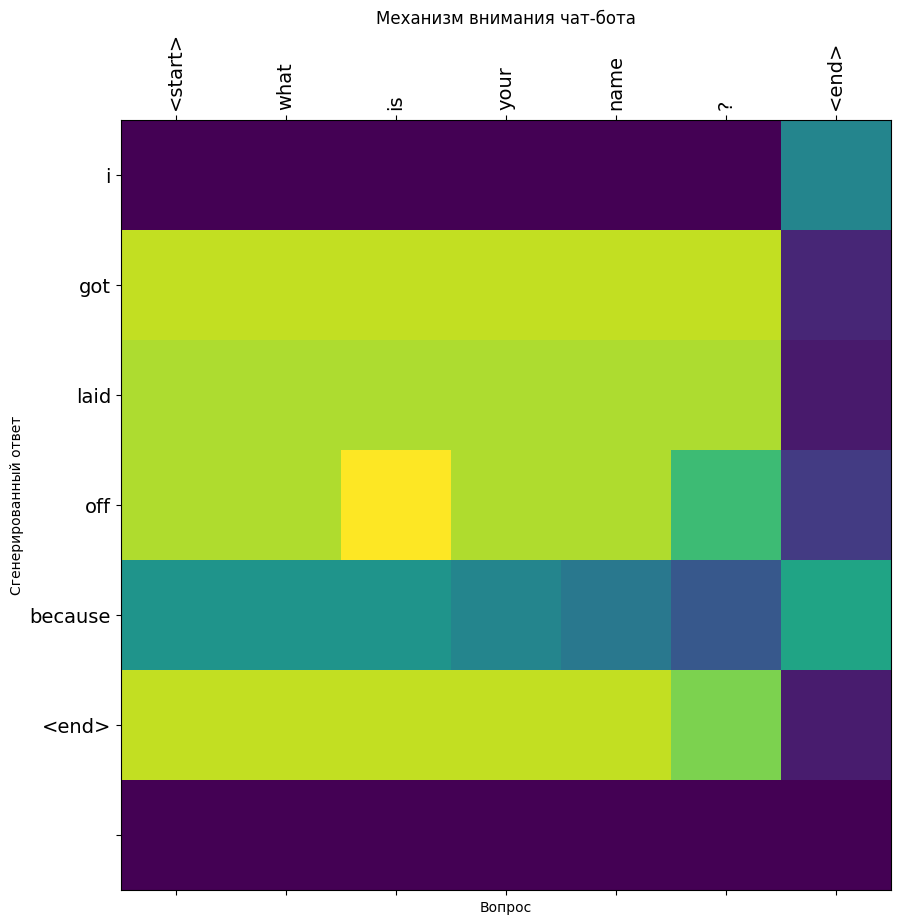

In [ ]:
translate('what is your name?')

Ввод: <start> Hello <end>
Перевод: i don't know . <end> 


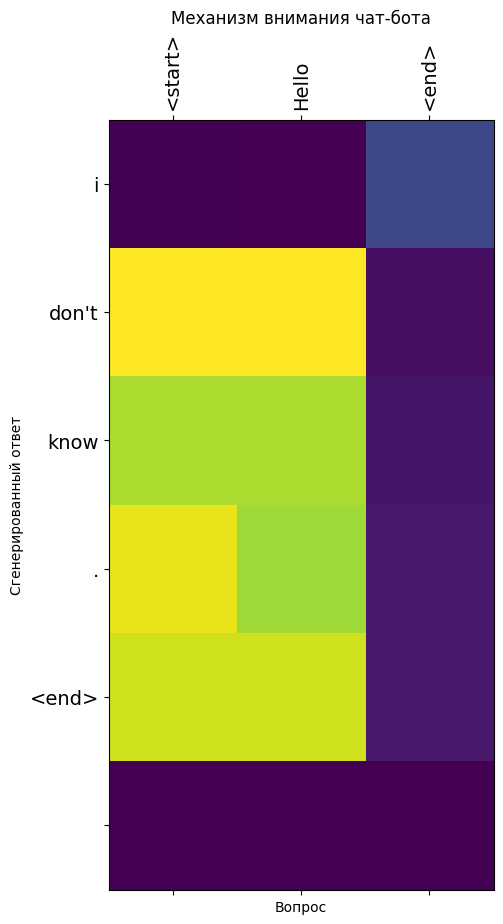

In [ ]:
translate('Hello')